## Purpose

The purpose is to finetune the chest-xray dataset with different pre-trained models to a decently good accuracy. This is followed by using the innvestigate toolbox to analyse the interpretability of each fine-tuned models with respect to the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Basic imports

In [0]:
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [0]:
!unzip -q 'drive/My Drive/Chest_X_rays/chest-xray-pneumonia.zip'

The data is now stored in the chest_xray folder.

In [0]:
path = 'chest_xray/chest_xray/'
train_path = path + 'train/'
test_path = path + 'test/'
val_path = path + 'val/'

## Create functions

In [0]:
def get_data(path,limit):
  
  ''' Given a path, this function returns four lists created from the path -
  
     eg. 'path = 'train_path'' returns data in the NORMAL / PNEUMONIA folders
     corresponding to this path
     
     limit is imposed to save memory, this means the no. of data obtained is only
     up to that limit
  
  
     samples_normal : all samples for the 'NORMAL' images
     filenames_normal : filenames corresponding to samples_normal
      
     samples_pneumonia : all samples for the 'PNEUMONIA' images
     filenames_pneumonia: filenames corresponding to samples_pneumonia
      
  '''

  samples_normal, samples_pneumonia = [], []
  filenames_normal, filenames_pneumonia = [], []

  # Get data for normal images
  for filename in os.listdir(path + 'NORMAL')[:limit]:
  
    if filename != '.DS_Store':
      image = Image.open(os.path.join(path + 'NORMAL', filename))
      imarray = np.array(image)
      samples_normal.append(imarray)
      filenames_normal.append(filename)
  
  print('Files in first {} images of {} appended!'.format(limit,path + 'NORMAL'))

  
  # Get data for pneumonia images
  for filename in os.listdir(path + 'PNEUMONIA')[:limit]:
  
    if filename != '.DS_Store':
      image = Image.open(os.path.join(path + 'PNEUMONIA', filename))
      imarray = np.array(image)
      samples_pneumonia.append(imarray)
      filenames_pneumonia.append(filename)
  
  print('Files in first {} images of {} appended!'.format(limit,path + 'PNEUMONIA'))


  return samples_normal, samples_pneumonia, filenames_normal, filenames_pneumonia
 

In [6]:
# Get the first 50 samples in training path : 'NORMAL' & 'PNEUMONIA'
samples_normal, samples_pneumonia, _, _ = get_data(train_path,50)

Files in first 50 images of chest_xray/chest_xray/train/NORMAL appended!
Files in first 50 images of chest_xray/chest_xray/train/PNEUMONIA appended!


## Visualise a few samples

In [0]:
def visualise_images(samples_normal, samples_pneumonia):
  
  plt.figure(figsize=(15,15))
  all_samples = samples_normal + samples_pneumonia

  # Plot 6 random samples
  for i in range(6):
    plt.subplot(2,3,i+1)
    plt.subplots_adjust(bottom=0.3, top=0.9, hspace=0)
    k = np.random.choice(len(all_samples))
    label = 'NORMAL' if k <= (0.5*len(all_samples)-1) else 'PNEUMONIA'
    plt.xlabel('True label : {}'.format(label),fontsize=15)
    plt.imshow(all_samples[k].squeeze(), cmap=plt.get_cmap('gray'), interpolation='nearest')


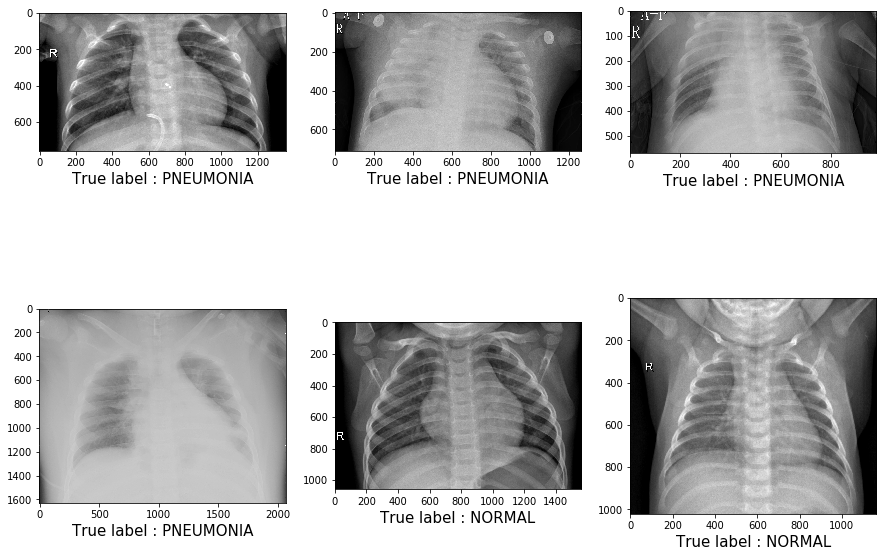

In [8]:
visualise_images(samples_normal, samples_pneumonia)

- Images are of different sizes
- Some samples of NORMAL / PNEUMONIA images are shown

## Create train and test data generators

In [0]:
# Create train and test data gen

def create_train_test_val_generator(train_path,test_path,val_path,img_size=(96,96),batch_size=16,
                                    shear_range=0.2,zoom_range=0.2):
  
  # Create generators
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range=shear_range,
      zoom_range=zoom_range,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(rescale=1./255)
  
  # Generate from path
  train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')
  
  validation_generator = test_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')
  
  test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')
  

  return train_generator, validation_generator, test_generator

In [54]:
train_generator, validation_generator, test_generator = create_train_test_val_generator(train_path,test_path,\
                                                                                        val_path,img_size=(96,96),batch_size=16,
                                                                                        shear_range=0.3,zoom_range=0.3)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
# Use only the train and test

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [0]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [78]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# If no improvement in validation loss, we stop the training
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# If no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

history = model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=20,
                   callbacks=[reducel, earlystopper])

Epoch 1/20
326/326 [==============================] - 91s 278ms/step - loss: 0.5784 - acc: 0.7487 - val_loss: 0.5650 - val_acc: 0.7019
Epoch 2/20
326/326 [==============================] - 70s 215ms/step - loss: 0.3854 - acc: 0.8386 - val_loss: 0.3484 - val_acc: 0.8766
Epoch 3/20
326/326 [==============================] - 72s 221ms/step - loss: 0.3065 - acc: 0.8804 - val_loss: 0.3255 - val_acc: 0.8365
Epoch 4/20
326/326 [==============================] - 73s 224ms/step - loss: 0.2888 - acc: 0.8967 - val_loss: 0.3002 - val_acc: 0.8894
Epoch 5/20
326/326 [==============================] - 72s 220ms/step - loss: 0.2570 - acc: 0.9026 - val_loss: 0.2537 - val_acc: 0.9103
Epoch 6/20
326/326 [==============================] - 72s 220ms/step - loss: 0.2305 - acc: 0.9147 - val_loss: 0.3314 - val_acc: 0.8782

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/20
326/326 [==============================] - 72s 219ms/step - loss: 0.1750 - acc: 0.9325 - val_loss

In [0]:
#model.save_weights('train_from_scratch_weights.h5')

In [85]:
model.evaluate_generator(validation_generator)

[0.4204398989677429, 0.8125]

In [89]:
validation_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [94]:
model.predict_generator(validation_generator).argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])